In [1]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, csc_matrix, lil_matrix, dok_matrix, issparse, coo_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim
from torch.autograd import Variable
import sympy as sp
from collections import Counter

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def cubic_bonds(): #8 vertices
    """
    Defines the connectivity of a true 8-vertex cubic molecular structure.

    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
    (0, 1), (0, 2), (0, 4),
    (1, 3), (1, 5),
    (2, 3), (2, 6),
    (3, 7),
    (4, 5), (4, 6),
    (5, 7),
    (6, 7)
    ]
    return bonds


def transverse_field_ising_cubic(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a cubic molecular structure.

    Parameters:
        N (int): Number of spins (should match the cubic molecule, typically N=8).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 8:
        raise ValueError("Cubic molecules typically have N = 8 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)

    # Get cubic bonds
    bonds = cubic_bonds()

    # Interaction term: J * sigma_i^x * sigma_j^x for cubic connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_cubic(N, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on a cubic molecular structure.

    Parameters:
        N (int): Number of spins (should match the cubic molecule, typically N=8).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 8:
        raise ValueError("Cubic molecules typically have N = 8 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = cubic_bonds()
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

#######################################################################################################################

'''
def partial_trace_qubit(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits."""
    keep_dims = np.prod([dims[i] for i in keep])
    trace_dims = np.prod([dims[i] for i in range(len(dims)) if i not in keep])
    rho = rho.reshape([keep_dims, trace_dims, keep_dims, trace_dims])
    return np.trace(rho, axis1=1, axis2=3).reshape([keep_dims, keep_dims])

def partial_trace_qubit_torch(rho, keep, dims):
    """Compute the partial trace of a density matrix of qubits using PyTorch."""
    keep_dims = torch.prod(torch.tensor([dims[i] for i in keep]))
    trace_dims = torch.prod(torch.tensor([dims[i] for i in range(len(dims)) if i not in keep]))
    rho = rho.view(keep_dims, trace_dims, keep_dims, trace_dims)
    # Compute the partial trace
    traced_rho = torch.zeros((keep_dims, keep_dims), dtype=rho.dtype)
    for i in range(trace_dims):
        traced_rho += rho[:, i, :, i]
    #return traced_rho.view(keep_dims, keep_dims)
    return traced_rho'''

def isket_numpy(arr):
    """
    Check if a NumPy array is a ket (column vector).

    Parameters:
    - arr: np.ndarray, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_numpy(Q, sel, dims): # numpy function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using NumPy.

    Parameters:
    - Q: numpy object, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - numpy object, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = np.asarray(dims[0], dtype=np.int32).ravel()
    nd = len(rd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = np.array([sel])
    else:
        sel = np.asarray(sel)
    sel = list(np.sort(sel))
    
    # Dimensions of the subsystems to keep
    dkeep = (rd[sel]).tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(np.arange(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = (rd[qtrace]).tolist()
    
    # Reshape the density matrix or state vector
    rd = list(rd)
    if isket_numpy(Q):
        # Reshape and transpose for state vector
        vmat = (Q
                .reshape(rd)
                .transpose(sel + qtrace)
                .reshape([np.prod(dkeep), np.prod(dtrace)]))
        # Compute the reduced density matrix
        rhomat = vmat.dot(vmat.conj().T)
    else:
        # Reshape and transpose for density matrix
        rhomat = np.trace(Q
                          .reshape(rd + rd)
                          .transpose(qtrace + [nd + q for q in qtrace] +
                                     sel + [nd + q for q in sel])
                          .reshape([np.prod(dtrace),
                                    np.prod(dtrace),
                                    np.prod(dkeep),
                                    np.prod(dkeep)]))
    return rhomat


def ptrace_sparse(psi_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        psi_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(psi_sparse):
        raise ValueError("psi_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if psi_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    def idx_to_bits(idx):
        return np.array(list(np.binary_repr(idx, width=n))).astype(int)
    

    psi_sparse = psi_sparse.tocoo()
    for i, j, val in zip(psi_sparse.row, psi_sparse.col, psi_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)


        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)


            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)
    
    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()


def isket_torch(arr):
    """
    Check if a PyTorch tensor is a ket (column vector).

    Parameters:
    - arr: torch.Tensor, the array to check.

    Returns:
    - bool, True if the array is a ket, False otherwise.
    """
    if not isinstance(arr, torch.Tensor):
        raise ValueError("Input must be a PyTorch tensor")

    shape = arr.shape

    if len(shape) == 2 and shape[1] == 1:
        return True
    else:
        return False

def ptrace_torch(Q, sel, dims): # torch function adapted from ptrace of qutip
    """
    Compute the partial trace of a density matrix of qubits using PyTorch.

    Parameters:
    - Q: torch.Tensor, the quantum object (density matrix or state vector).
    - sel: list of int, indices of the subsystems to keep.
    - dims: list of int, dimensions of the subsystems.

    Returns:
    - torch.Tensor, the reduced density matrix after tracing out the specified subsystems.
    """
    # Get the dimensions of the subsystems
    rd = torch.tensor(dims[0], dtype=torch.int32).flatten()
    nd = len(rd)
    #print("rd", rd)
    #print("nd", nd)
    
    # Ensure sel is a sorted array of indices
    if isinstance(sel, int):
        sel = torch.tensor([sel])
    else:
        sel = torch.tensor(sel)
    sel = torch.sort(sel).values.tolist()
    
    # Dimensions of the subsystems to keep
    dkeep = rd[sel].tolist()
    
    # Indices of the subsystems to trace out
    qtrace = list(set(range(nd)) - set(sel))
    
    # Dimensions of the subsystems to trace out
    dtrace = rd[qtrace].tolist()
    
    # Reshape the density matrix or state vector
    rd = rd.tolist()
    if isket_torch(Q):
        # Reshape and transpose for state vector
        reshaped_Q = Q.reshape(rd)
        #print(reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(sel + qtrace)
        #print(transposed_Q.shape)
        vmat = transposed_Q.reshape([torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dtrace))])
        #print(vmat.shape)
        # Compute the reduced density matrix
        rhomat = vmat @ vmat.conj().T
        #print(rhomat.shape)
    else:
        # Reshape and transpose for density matrix
        reshaped_Q = Q.reshape(rd + rd)
        #print("reshaped_Q", reshaped_Q.shape)
        transposed_Q = reshaped_Q.permute(qtrace + [nd + q for q in qtrace] + sel + [nd + q for q in sel])
        #print("transposed_Q", transposed_Q.shape)
        reshaped_transposed_Q = transposed_Q.reshape([torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dtrace)), torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))])
        #print("reshaped_transposed_Q", reshaped_transposed_Q.shape)
        #rhomat = torch.trace(reshaped_transposed_Q)
        rhomat = torch.einsum('iikl->kl', reshaped_transposed_Q)
        # Trace out the first two dimensions
        #rhomat = torch.zeros((torch.prod(torch.tensor(dkeep)), torch.prod(torch.tensor(dkeep))), dtype=Q.dtype)
        #for i in range(reshaped_transposed_Q.shape[0]):
        #    for j in range(reshaped_transposed_Q.shape[1]):
        #        rhomat += reshaped_transposed_Q[i, j, :, :]
        #print("rhomat", rhomat.shape)
    return rhomat

def entanglement_entropy(psi, subsystem, total_size):

    '''Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.'''
    
    psi_matrix =  np.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_numpy(psi_matrix, subsystem, [[2]*total_size, [2]*total_size])  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch(psi, subsystem, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state using PyTorch.

    Parameters:
    - psi: torch.Tensor (complex), the wavefunction (state vector) of the full system.
    - subsystem_size: int, the number of qubits in subsystem A.
    - total_size: int, the total number of qubits in the system.

    Returns:
    - torch.Tensor (scalar), the von Neumann entanglement entropy S_A.
    """

    if not isinstance(psi, torch.Tensor):
        psi = torch.tensor(psi, dtype=torch.complex64)
    
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Compute the density matrix |psi><psi|
    psi_matrix = torch.outer(psi, psi.conj())

    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = ptrace_torch(psi_matrix, subsystem, [[2] * total_size, [2] * total_size])  # Partial trace over B

    #rho_A = rho_A.to(dtype=torch.float64)
    
    # Compute eigenvalues of rho_A
    eigvals = torch.linalg.eigvalsh(rho_A)

    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigvals = eigvals[eigvals > 0]

    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -torch.sum(eigvals * torch.log2(eigvals))

    return entropy

def entanglement_entropy_qutip(psi, subsystem, total_size):
    
    # Convert the wavefunction to a QuTiP Qobj
    density_matrix = np.outer(psi, psi.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*total_size, [2]*total_size])

    rho_A = ptrace(density_matrix_qobj, subsystem)
    # Compute the von Neumann entropy S_A
    entropy = entropy_vn(rho_A, base=2)
    
    return entropy

def entanglement_entropy_np_ptrace(rdm):
    # rdm already computed and converted to numpy
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rdm)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

def entanglement_entropy_torch_ptrace(rdm):

    eigvals = torch.linalg.eigvalsh(rdm)
    eigvals = eigvals[eigvals > 0]
    entropy = -torch.sum(eigvals * torch.log2(eigvals))
    return entropy


def entanglement_entropy_qutip_torch(psi, N):
    """
    Compute the von Neumann entanglement entropy using qutip.

    Parameters:
    - psi: torch.Tensor (complex), state vector of a quantum system.
    - N: int, total number of qubits.

    Returns:
    - torch.Tensor (scalar), von Neumann entropy.
    """
    # Ensure psi is normalized
    psi = psi / torch.norm(psi)

    # Convert PyTorch tensor to NumPy for QuTiP
    psi_np = psi.detach().numpy()

    rho_np = np.outer(psi_np, psi_np.conj())
    rho_qobj = Qobj(rho_np, dims=[[2] * N, [2] * N])

    rho_A = ptrace(rho_qobj, list(range(N // 2)))

    # Compute von Neumann entropy
    entropy = entropy_vn(rho_A, base=2)  # Compute in log base 2

    # Convert back to PyTorch tensor to allow gradient flow
    return torch.tensor(entropy, dtype=torch.float32, requires_grad=True)

#######################################################################################################################

# Define the linear combination function - numpy
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

# Define the linear combination function - torch
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function - torch but after computing the ptrace of outer products of scars
def linear_combination_outer(coeffs, outs):
    # Ensure outs are PyTorch tensors
    outs_torch = [torch.tensor(out, dtype=torch.complex64) if not isinstance(out, torch.Tensor) else out for out in outs]
    torch_coeffs = torch.tensor(coeffs, dtype=torch.complex64)

    # Compute the PyTorch tensor of out_coeffs which is the product of all possible combinations of c_i^* times c_j
    out_coeffs = torch.zeros((len(torch_coeffs), len(torch_coeffs)), dtype=torch.complex64)
    for i in range(len(torch_coeffs)):
        for j in range(len(torch_coeffs)):
            out_coeffs[i, j] = torch.conj(torch_coeffs[i]) * torch_coeffs[j]
    
    # Compute the linear combination in PyTorch
    lin_torch = sum(out_coeffs[i, j] * outs_torch[i] for i in range(len(coeffs)) for j in range(len(coeffs)))
    
    return lin_torch

######################################################

# Function to apply permutation to a given spin configuration
def apply_permutation(state_bits, N, perm):
    new_bits = [0] * N
    for i in range(N):
        new_bits[perm[i]] = state_bits[i]  # Map value at index i to perm[i]
    return new_bits

# Function to convert an index to its binary representation
def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

In [3]:
N = 8  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

keep_qubits = [0,1]

trace_qubits = [i for i in range(N) if i not in keep_qubits]


# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_cubic(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

# Count the number of (near-)zero components in each eigenvector
zero_threshold = 1e-6
zero_counts = []
for i in range(eigenvectors.shape[1]):
    num_nnzeros = np.sum(np.abs(eigenvectors[:, i]) > zero_threshold)
    zero_counts.append(num_nnzeros)
    print(f"Eigenvector {i}, eigenvalue {eigenvalues[i]}: {num_nnzeros} components > {zero_threshold}")

# Optionally, print a summary
print("Zero count distribution:", Counter(zero_counts))

# Check if each eigenvector is complex or real
for i in range(eigenvectors.shape[1]):
    vec = eigenvectors[:, i]
    #if np.any(np.abs(vec.imag) > 1e-14):
    #    print(f"Eigenvector {i} is complex.")
    #else:
    #    print(f"Eigenvector {i} is real.")

Eigenvalues of H: [-2.51148029e+01 -2.23928752e+01 -1.95189103e+01 -1.95189103e+01
 -1.95189103e+01 -1.82322200e+01 -1.76895343e+01 -1.76895343e+01
 -1.76895343e+01 -1.62319057e+01 -1.52667584e+01 -1.52667584e+01
 -1.52667584e+01 -1.45241593e+01 -1.45241593e+01 -1.45241593e+01
 -1.42737990e+01 -1.42737990e+01 -1.31602102e+01 -1.30224159e+01
 -1.24986360e+01 -1.24986360e+01 -1.24986360e+01 -1.24947995e+01
 -1.24947995e+01 -1.24947995e+01 -1.21655251e+01 -1.21655251e+01
 -1.19961448e+01 -1.04783206e+01 -1.04783206e+01 -1.04783206e+01
 -1.04407254e+01 -1.04407254e+01 -1.02868712e+01 -1.02868712e+01
 -1.02868712e+01 -9.78233499e+00 -9.78233499e+00 -9.78233499e+00
 -9.31765123e+00 -9.31765123e+00 -9.31765123e+00 -8.84746183e+00
 -8.64431788e+00 -8.64431788e+00 -8.64431788e+00 -8.64431788e+00
 -8.64431788e+00 -7.98178198e+00 -7.98178198e+00 -7.98178198e+00
 -7.94027872e+00 -7.94027872e+00 -7.94027872e+00 -7.88068701e+00
 -6.86925815e+00 -6.66295410e+00 -6.64431788e+00 -6.64431788e+00
 -6.644

In [5]:
##################### RDMS + EE #################################

  0%|          | 0/256 [00:00<?, ?it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16351


  0%|          | 1/256 [00:00<01:31,  2.79it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


  1%|          | 2/256 [00:00<01:21,  3.10it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 13468


  1%|          | 3/256 [00:01<01:25,  2.96it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 12648


  2%|▏         | 4/256 [00:01<01:28,  2.85it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 12776


  2%|▏         | 5/256 [00:01<01:21,  3.08it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


  2%|▏         | 6/256 [00:01<01:21,  3.07it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 14616


  3%|▎         | 7/256 [00:02<01:22,  3.03it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 14304


  3%|▎         | 8/256 [00:02<01:20,  3.08it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 14700


  4%|▎         | 9/256 [00:02<01:15,  3.27it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


  4%|▍         | 10/256 [00:03<01:17,  3.17it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11492


  5%|▍         | 12/256 [00:03<01:08,  3.55it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11668
Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11556


  5%|▌         | 13/256 [00:03<01:05,  3.74it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13524


  5%|▌         | 14/256 [00:04<01:03,  3.82it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13785


  6%|▌         | 15/256 [00:04<01:00,  4.02it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13756


  6%|▋         | 16/256 [00:04<01:02,  3.84it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11536


  7%|▋         | 18/256 [00:05<00:59,  4.02it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11552
Nonzero elements in state vector (tol=1e-12): 58
Number of nonzero elements of dm (tol=1e-12): 3364
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


  8%|▊         | 21/256 [00:05<00:45,  5.19it/s]

Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5156
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5020
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5092


  9%|▉         | 23/256 [00:05<00:34,  6.77it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13363


  9%|▉         | 24/256 [00:06<00:37,  6.19it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 11936


 10%|▉         | 25/256 [00:06<00:40,  5.67it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 12496


 10%|█         | 26/256 [00:06<00:43,  5.25it/s]

Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2160
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 12%|█▏        | 30/256 [00:07<00:37,  6.07it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 11272
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 12864


 12%|█▎        | 32/256 [00:07<00:41,  5.41it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13539
Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11648


 13%|█▎        | 34/256 [00:08<00:45,  4.91it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11648
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16364


 14%|█▎        | 35/256 [00:08<00:50,  4.41it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16304


 14%|█▍        | 36/256 [00:08<00:52,  4.22it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16284


 15%|█▍        | 38/256 [00:09<00:49,  4.38it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 15%|█▌        | 39/256 [00:09<00:47,  4.53it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11312


 16%|█▌        | 40/256 [00:09<00:48,  4.45it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12084
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16364


 16%|█▌        | 41/256 [00:09<00:49,  4.33it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16292


 16%|█▋        | 42/256 [00:09<00:50,  4.24it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16260


 17%|█▋        | 43/256 [00:10<00:52,  4.08it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 18%|█▊        | 45/256 [00:10<00:51,  4.09it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212


 18%|█▊        | 47/256 [00:11<00:46,  4.49it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9200


 19%|█▉        | 49/256 [00:11<00:38,  5.31it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16140


 20%|█▉        | 50/256 [00:11<00:44,  4.64it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16204


 20%|█▉        | 51/256 [00:12<00:51,  3.96it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16000


 20%|██        | 52/256 [00:12<00:51,  3.94it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 21%|██        | 53/256 [00:12<00:52,  3.84it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16276


 21%|██        | 54/256 [00:12<00:53,  3.74it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16292


 21%|██▏       | 55/256 [00:13<00:58,  3.42it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 22%|██▏       | 56/256 [00:13<01:04,  3.09it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 22%|██▏       | 57/256 [00:13<00:59,  3.32it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 23%|██▎       | 59/256 [00:14<00:48,  4.04it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 8848
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212


 24%|██▍       | 61/256 [00:14<00:38,  5.05it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9156


 25%|██▍       | 63/256 [00:14<00:37,  5.21it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9152
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 25%|██▌       | 64/256 [00:15<00:51,  3.70it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16108


 25%|██▌       | 65/256 [00:15<00:52,  3.67it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16272


 26%|██▌       | 66/256 [00:15<00:54,  3.49it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16304


 26%|██▌       | 67/256 [00:16<00:56,  3.37it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 27%|██▋       | 68/256 [00:16<00:59,  3.15it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16332


 27%|██▋       | 70/256 [00:17<00:50,  3.66it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9056


 28%|██▊       | 71/256 [00:17<00:44,  4.17it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 29%|██▊       | 73/256 [00:17<00:36,  4.97it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 29%|██▉       | 74/256 [00:17<00:40,  4.48it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 29%|██▉       | 75/256 [00:18<00:51,  3.52it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 30%|██▉       | 76/256 [00:18<00:51,  3.46it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16364


 30%|███       | 77/256 [00:18<00:53,  3.34it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16300


 30%|███       | 78/256 [00:19<00:51,  3.44it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 31%|███       | 79/256 [00:19<00:54,  3.23it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16280


 31%|███▏      | 80/256 [00:19<00:50,  3.46it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16252


 32%|███▏      | 81/256 [00:20<00:50,  3.45it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16320


 32%|███▏      | 82/256 [00:20<00:51,  3.35it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12052


 32%|███▏      | 83/256 [00:20<00:48,  3.54it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 33%|███▎      | 84/256 [00:21<00:51,  3.33it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12068


 34%|███▎      | 86/256 [00:21<00:42,  3.97it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 34%|███▍      | 88/256 [00:21<00:37,  4.50it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9192


 35%|███▍      | 89/256 [00:22<00:37,  4.50it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 35%|███▌      | 90/256 [00:22<00:38,  4.30it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 36%|███▌      | 91/256 [00:22<00:43,  3.83it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 36%|███▌      | 92/256 [00:22<00:43,  3.81it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 36%|███▋      | 93/256 [00:23<00:41,  3.90it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11664


 37%|███▋      | 95/256 [00:23<00:37,  4.28it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11664
Nonzero elements in state vector (tol=1e-12): 58
Number of nonzero elements of dm (tol=1e-12): 3364
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16352


 38%|███▊      | 97/256 [00:23<00:30,  5.14it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 15768


 38%|███▊      | 98/256 [00:24<00:34,  4.63it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 39%|███▉      | 101/256 [00:24<00:26,  5.82it/s]

Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 40%|████      | 103/256 [00:24<00:26,  5.83it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16276


 41%|████      | 104/256 [00:25<00:28,  5.32it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16316


 41%|████      | 105/256 [00:25<00:30,  4.93it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16332


 43%|████▎     | 109/256 [00:25<00:18,  8.07it/s]

Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13876
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 43%|████▎     | 111/256 [00:26<00:22,  6.50it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 11392


 44%|████▍     | 113/256 [00:26<00:24,  5.78it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12096


 45%|████▍     | 114/256 [00:26<00:24,  5.68it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 45%|████▍     | 115/256 [00:27<00:25,  5.64it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 45%|████▌     | 116/256 [00:27<00:28,  4.98it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15870


 46%|████▌     | 117/256 [00:27<00:30,  4.62it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15875


 46%|████▌     | 118/256 [00:27<00:31,  4.42it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15831


 46%|████▋     | 119/256 [00:28<00:32,  4.23it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15836


 47%|████▋     | 120/256 [00:28<00:33,  4.01it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15655


 47%|████▋     | 121/256 [00:28<00:33,  4.01it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15853


 48%|████▊     | 122/256 [00:28<00:33,  3.97it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15876


 48%|████▊     | 123/256 [00:29<00:33,  3.92it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15820


 48%|████▊     | 124/256 [00:29<00:34,  3.87it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15867


 49%|████▉     | 125/256 [00:29<00:33,  3.87it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15760


 49%|████▉     | 126/256 [00:29<00:34,  3.81it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15872


 50%|████▉     | 127/256 [00:30<00:33,  3.90it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15875


 50%|█████     | 128/256 [00:30<00:32,  3.90it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15876


 50%|█████     | 129/256 [00:30<00:33,  3.84it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15872


 51%|█████     | 130/256 [00:30<00:31,  3.95it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15812


 51%|█████     | 131/256 [00:31<00:31,  3.98it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15844


 52%|█████▏    | 132/256 [00:31<00:31,  3.98it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15827


 52%|█████▏    | 133/256 [00:31<00:31,  3.85it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15853


 52%|█████▏    | 134/256 [00:31<00:31,  3.87it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15867


 53%|█████▎    | 135/256 [00:32<00:31,  3.87it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15793


 53%|█████▎    | 136/256 [00:32<00:34,  3.49it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15876


 54%|█████▍    | 138/256 [00:32<00:26,  4.39it/s]

Nonzero elements in state vector (tol=1e-12): 82
Number of nonzero elements of dm (tol=1e-12): 6724
Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15813


 54%|█████▍    | 139/256 [00:33<00:28,  4.16it/s]

Nonzero elements in state vector (tol=1e-12): 126
Number of nonzero elements of dm (tol=1e-12): 15855


 55%|█████▍    | 140/256 [00:33<00:30,  3.84it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 55%|█████▌    | 141/256 [00:33<00:31,  3.69it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 55%|█████▌    | 142/256 [00:34<00:31,  3.60it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11148


 56%|█████▌    | 143/256 [00:34<00:29,  3.78it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 56%|█████▋    | 144/256 [00:34<00:28,  3.96it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 57%|█████▋    | 145/256 [00:34<00:29,  3.80it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13728


 57%|█████▋    | 146/256 [00:35<00:28,  3.80it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 58%|█████▊    | 149/256 [00:35<00:17,  6.24it/s]

Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2304
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16380


 59%|█████▉    | 151/256 [00:35<00:16,  6.24it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16136


 59%|█████▉    | 152/256 [00:36<00:18,  5.49it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 60%|█████▉    | 153/256 [00:36<00:21,  4.69it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 61%|██████    | 156/256 [00:36<00:17,  5.68it/s]

Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5184
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16144


 62%|██████▏   | 158/256 [00:37<00:19,  5.01it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 62%|██████▏   | 159/256 [00:37<00:22,  4.39it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16356


 62%|██████▎   | 160/256 [00:37<00:22,  4.22it/s]

Nonzero elements in state vector (tol=1e-12): 58
Number of nonzero elements of dm (tol=1e-12): 3364
Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11664


 64%|██████▎   | 163/256 [00:38<00:18,  4.99it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11664
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13915


 64%|██████▍   | 164/256 [00:38<00:19,  4.64it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 64%|██████▍   | 165/256 [00:38<00:21,  4.30it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13924


 65%|██████▌   | 167/256 [00:39<00:19,  4.57it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 66%|██████▌   | 168/256 [00:39<00:18,  4.89it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 66%|██████▋   | 170/256 [00:39<00:15,  5.51it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9200
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212


 67%|██████▋   | 171/256 [00:40<00:15,  5.58it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12052


 67%|██████▋   | 172/256 [00:40<00:16,  5.19it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 68%|██████▊   | 173/256 [00:40<00:17,  4.87it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 68%|██████▊   | 174/256 [00:40<00:19,  4.18it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16188


 68%|██████▊   | 175/256 [00:41<00:20,  4.03it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16304


 69%|██████▉   | 176/256 [00:41<00:20,  3.90it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16380


 69%|██████▉   | 177/256 [00:41<00:21,  3.65it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 70%|██████▉   | 178/256 [00:41<00:21,  3.56it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 70%|██████▉   | 179/256 [00:42<00:22,  3.43it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16156


 70%|███████   | 180/256 [00:42<00:21,  3.54it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 71%|███████   | 181/256 [00:42<00:21,  3.49it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 71%|███████▏  | 183/256 [00:43<00:18,  3.95it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9176


 72%|███████▏  | 185/256 [00:43<00:15,  4.52it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9200
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9204


 73%|███████▎  | 187/256 [00:44<00:14,  4.79it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 73%|███████▎  | 188/256 [00:44<00:14,  4.67it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16088


 74%|███████▍  | 189/256 [00:44<00:14,  4.60it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16364


 74%|███████▍  | 190/256 [00:44<00:14,  4.44it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16060


 75%|███████▍  | 191/256 [00:45<00:14,  4.36it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16308


 75%|███████▌  | 192/256 [00:45<00:15,  4.15it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16220


 76%|███████▌  | 194/256 [00:45<00:13,  4.77it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 77%|███████▋  | 196/256 [00:45<00:11,  5.40it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216


 77%|███████▋  | 198/256 [00:46<00:09,  5.99it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9212
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 78%|███████▊  | 199/256 [00:46<00:10,  5.37it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 78%|███████▊  | 200/256 [00:46<00:11,  4.93it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 79%|███████▊  | 201/256 [00:47<00:12,  4.27it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16352


 79%|███████▉  | 202/256 [00:47<00:12,  4.20it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16372


 79%|███████▉  | 203/256 [00:47<00:12,  4.19it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16288


 80%|███████▉  | 204/256 [00:47<00:12,  4.14it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16288


 80%|████████  | 205/256 [00:48<00:12,  4.07it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16256


 80%|████████  | 206/256 [00:48<00:12,  4.11it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16320


 81%|████████▏ | 208/256 [00:48<00:10,  4.74it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9204
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9108


 82%|████████▏ | 210/256 [00:49<00:09,  4.96it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9108


 82%|████████▏ | 211/256 [00:49<00:08,  5.41it/s]

Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9216
Nonzero elements in state vector (tol=1e-12): 96
Number of nonzero elements of dm (tol=1e-12): 9204


 83%|████████▎ | 212/256 [00:49<00:07,  5.75it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 83%|████████▎ | 213/256 [00:49<00:08,  4.86it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16240


 84%|████████▎ | 214/256 [00:49<00:09,  4.48it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16368


 84%|████████▍ | 215/256 [00:50<00:10,  3.76it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16212


 85%|████████▍ | 217/256 [00:50<00:10,  3.87it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12084


 85%|████████▌ | 218/256 [00:50<00:08,  4.28it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100
Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 12100


 86%|████████▌ | 219/256 [00:51<00:08,  4.55it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16128


 86%|████████▌ | 220/256 [00:51<00:08,  4.24it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 15992


 86%|████████▋ | 221/256 [00:51<00:08,  3.92it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16172


 87%|████████▋ | 222/256 [00:52<00:09,  3.59it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11056


 88%|████████▊ | 224/256 [00:52<00:07,  4.01it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11664
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13417


 88%|████████▊ | 225/256 [00:52<00:07,  3.96it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 12096


 89%|████████▊ | 227/256 [00:53<00:06,  4.18it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13631
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 89%|████████▉ | 228/256 [00:53<00:07,  3.72it/s]

Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2288
Nonzero elements in state vector (tol=1e-12): 48
Number of nonzero elements of dm (tol=1e-12): 2288
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13508


 90%|█████████ | 231/256 [00:53<00:04,  5.65it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 12638


 91%|█████████ | 232/256 [00:54<00:04,  5.06it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13612


 91%|█████████▏| 234/256 [00:54<00:04,  5.15it/s]

Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 4996
Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 4844


 92%|█████████▏| 236/256 [00:54<00:03,  6.14it/s]

Nonzero elements in state vector (tol=1e-12): 72
Number of nonzero elements of dm (tol=1e-12): 5172
Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 93%|█████████▎| 237/256 [00:55<00:03,  5.27it/s]

Nonzero elements in state vector (tol=1e-12): 58
Number of nonzero elements of dm (tol=1e-12): 3364
Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 9856


 94%|█████████▍| 240/256 [00:55<00:02,  5.89it/s]

Nonzero elements in state vector (tol=1e-12): 108
Number of nonzero elements of dm (tol=1e-12): 11600
Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13548


 95%|█████████▍| 242/256 [00:55<00:02,  5.49it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13819


 95%|█████████▍| 243/256 [00:56<00:02,  5.30it/s]

Nonzero elements in state vector (tol=1e-12): 118
Number of nonzero elements of dm (tol=1e-12): 13811


 95%|█████████▌| 244/256 [00:56<00:02,  5.44it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11368
Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11648


 96%|█████████▌| 245/256 [00:56<00:02,  5.46it/s]

Nonzero elements in state vector (tol=1e-12): 110
Number of nonzero elements of dm (tol=1e-12): 11508


 96%|█████████▌| 246/256 [00:56<00:01,  5.13it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 96%|█████████▋| 247/256 [00:57<00:01,  4.64it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 14176


 97%|█████████▋| 248/256 [00:57<00:01,  4.31it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 15320


 97%|█████████▋| 249/256 [00:57<00:01,  4.13it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 14792


 98%|█████████▊| 250/256 [00:57<00:01,  3.82it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


 98%|█████████▊| 251/256 [00:58<00:01,  3.74it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 13288


 98%|█████████▊| 252/256 [00:58<00:01,  3.75it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 13500


 99%|█████████▉| 253/256 [00:58<00:00,  3.32it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 12608


 99%|█████████▉| 254/256 [00:59<00:00,  3.35it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16384


100%|█████████▉| 255/256 [00:59<00:00,  3.06it/s]

Nonzero elements in state vector (tol=1e-12): 128
Number of nonzero elements of dm (tol=1e-12): 16351


100%|██████████| 256/256 [00:59<00:00,  4.28it/s]
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


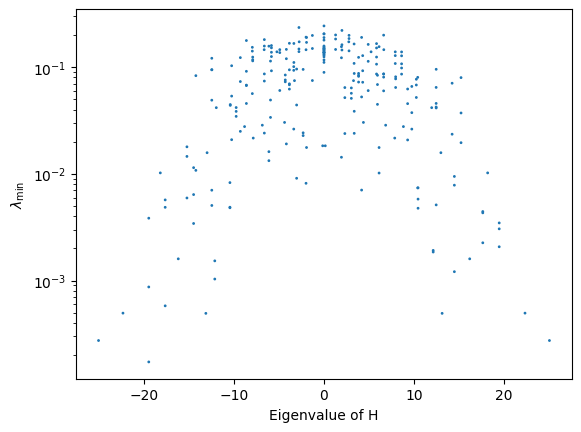

0 0
Eigenvalue: -25.114802878048362, rdm Minimum Eigenvalue: 0.000274605224508874
Eigenvector 0: rdm rank: 4
1 1
Eigenvalue: -22.39287522802269, rdm Minimum Eigenvalue: 0.000495762007079041
Eigenvector 1: rdm rank: 4
2 2
Eigenvalue: -19.51891027404601, rdm Minimum Eigenvalue: 0.0008715819354233934
Eigenvector 2: rdm rank: 4
3 3
Eigenvalue: -19.518910274046, rdm Minimum Eigenvalue: 0.00017308642041288878
Eigenvector 3: rdm rank: 4
4 4
Eigenvalue: -19.518910274046, rdm Minimum Eigenvalue: 0.003842390560977682
Eigenvector 4: rdm rank: 4
5 5
Eigenvalue: -18.232220015901202, rdm Minimum Eigenvalue: 0.010203161811774247
Eigenvector 5: rdm rank: 4
6 6
Eigenvalue: -17.68953431717526, rdm Minimum Eigenvalue: 0.004856408049912327
Eigenvector 6: rdm rank: 4
7 7
Eigenvalue: -17.689534317175255, rdm Minimum Eigenvalue: 0.005698517395059805
Eigenvector 7: rdm rank: 4
8 8
Eigenvalue: -17.68953431717525, rdm Minimum Eigenvalue: 0.0005802300084759978
Eigenvector 8: rdm rank: 4
9 9
Eigenvalue: -16.23190

In [7]:
# rdm - sparse

min_eigenvalues_sparse = []
min_rdms_sparse = []
rdm_ranks_sparse = []

for i in tqdm(range(eigenvectors.shape[1])):
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    density_matrix_sparse = min_eig_sparse @ min_eig_sparse.getH()  # Outer product to form density matrix

    print("Number of nonzero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-6))    #Trace out qubits using qutip partial trace
    rdm = ptrace_sparse(density_matrix_sparse, keep_qubits, [2]*N) # Use the custom ptrace_sparse function
    # Find the minimum eigenvalue of the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues_sparse.append(min_eigenvalue)


    min_rdms_sparse.append(rdm)  # store the sparse RDM
    rdm_ranks_sparse.append(np.linalg.matrix_rank(rdm.toarray()))  # store the rank

# Define the threshold
threshold = 1e-16
min_eigenvalues_sparse = np.array(min_eigenvalues_sparse)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_sparse if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_sparse]


# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_sparse), color=colors, s=1)
plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - sparse
#red_indices_sparse = [i for i, y in enumerate(min_eigenvalues_sparse) if y < threshold]
#print(f'Indices of red points: {red_indices_sparse}')

red_eigenvectors_sparse = []

# Print eigenvalues, RDM minimum eigenvalues, and ranks for red points
for i, ind in enumerate(range(len(min_eigenvalues_sparse))):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_sparse[i]}')
    print(f'Eigenvector {ind}: rdm rank: {rdm_ranks_sparse[i]}')
    red_eigenvectors_sparse.append(eigenvectors[:, ind])

# Print the ranks of the scarred rdms
print(f'Ranks of the scarred rdms: {rdm_ranks_sparse}')

In [8]:
# scars + tf field - sparse

for i in tqdm(range(eigenvectors.shape[1])):
    # Construct the density matrix for each eigenvector (as sparse)
    min_eigenvector = eigenvectors[:, i]
    print("Nonzero elements in state vector (tol=1e-12):", np.sum(np.abs(min_eigenvector) > 1e-6))
    min_eigenvector[np.abs(min_eigenvector) < 1e-7] = 0
    min_eig_sparse = csr_matrix(min_eigenvector.reshape(-1, 1))  # Convert to sparse column vector
    
    # Apply the transverse field operator to the sparse vector
    vecs = transverse_field_cubic(N, h) @ min_eig_sparse
    vecs = vecs.toarray()  # Convert to dense array for further processing
    
    # Print information about the result
    print(f"Shape of result: {vecs.shape}")
    print(f"for {i}-th eigenvector: Number of nonzero elements in result: {np.count_nonzero(vecs)}")
    print(f"Max absolute value in result: {np.max(np.abs(vecs.data))}")

  3%|▎         | 7/256 [00:00<00:03, 65.83it/s]

Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 0-th eigenvector: Number of nonzero elements in result: 58
Max absolute value in result: 22.62704194441719
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 1-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 5.949548432995964
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 2-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 7.1642031423684385
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 3-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 9.410896986612709
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 4-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 8.958380544541539
Nonzero elements in state vector (tol=1e-12): 128
Shape of r

  8%|▊         | 20/256 [00:00<00:04, 57.34it/s]

Shape of result: (256, 1)
for 11-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.896002140144839
Nonzero elements in state vector (tol=1e-12): 110
Shape of result: (256, 1)
for 12-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 4.0748824601549
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 13-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.7409099846899565
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 14-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 6.5568056278313325
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 15-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.836133570503358
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 16-th eigenvector: Number of n

 13%|█▎        | 34/256 [00:00<00:03, 59.17it/s]

Shape of result: (256, 1)
for 26-th eigenvector: Number of nonzero elements in result: 24
Max absolute value in result: 4.848854108469629
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 27-th eigenvector: Number of nonzero elements in result: 24
Max absolute value in result: 4.401207790444238
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 28-th eigenvector: Number of nonzero elements in result: 58
Max absolute value in result: 4.527519086676177
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 29-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.087371538976382
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 30-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 4.788760228818267
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 31-th eigenvector: Number of no

 19%|█▉        | 48/256 [00:00<00:03, 63.34it/s]

Shape of result: (256, 1)
for 38-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 4.022122340406603
Nonzero elements in state vector (tol=1e-12): 110
Shape of result: (256, 1)
for 39-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.9258796494757395
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 40-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.8053384056017476
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 41-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7277963925453326
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 42-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.8952510854672338
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 43-th eigenvector: Numb

 24%|██▍       | 62/256 [00:01<00:03, 58.36it/s]

Shape of result: (256, 1)
for 53-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.6918826919886973
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 54-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.6884729457272738
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 55-th eigenvector: Number of nonzero elements in result: 58
Max absolute value in result: 2.617847566235684
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 56-th eigenvector: Number of nonzero elements in result: 58
Max absolute value in result: 1.46551658761351
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 57-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 0.9956077861600838
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 58-th eigenvector: Number 

 29%|██▉       | 74/256 [00:01<00:03, 50.90it/s]

Shape of result: (256, 1)
for 64-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7540292901675443
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 65-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.9478320275237124
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 66-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 2.0621949777441455
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 67-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7764977484916658
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 68-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 2.2079845924032617
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 69-th eigenvector: Nu

 34%|███▍      | 88/256 [00:01<00:02, 56.22it/s]

Shape of result: (256, 1)
for 76-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.5723177160588793
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 77-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.4596798201452859
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 78-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7105844581070595
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 79-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7606597573621414
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 80-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.736727342998385
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 81-th eigenvector: Nu

 39%|███▉      | 101/256 [00:01<00:02, 53.65it/s]

Shape of result: (256, 1)
for 91-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.9958359587317187
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 92-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.9284565917460255
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 93-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 0.6281819447783819
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 94-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 0.6303421318200555
Nonzero elements in state vector (tol=1e-12): 58
Shape of result: (256, 1)
for 95-th eigenvector: Number of nonzero elements in result: 24
Max absolute value in result: 0.6897996631635717
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 96-th eigenvector: Number 

 45%|████▍     | 115/256 [00:02<00:02, 59.99it/s]

Shape of result: (256, 1)
for 106-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 107-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 108-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 109-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.6400319026950723
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 110-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.6707773206039771
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 111-th eigenvector: Number of nonzero elements in result: 56
Max absol

 50%|█████     | 128/256 [00:02<00:02, 54.79it/s]

Shape of result: (256, 1)
for 120-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.7157572715650731
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 121-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.8546980796607313
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 122-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.5237965119757906
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 123-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.7308174658496157
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 124-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.5620082671080779
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 125-th eigenvector: 

 55%|█████▌    | 142/256 [00:02<00:01, 59.10it/s]

Shape of result: (256, 1)
for 129-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.5578612074736261
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 130-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.8994794970507227
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 131-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.5828536637468471
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 132-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.5841048002807667
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 133-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.7384727224751004
Nonzero elements in state vector (tol=1e-12): 126
Shape of result: (256, 1)
for 134-th eigenvector: 

 61%|██████    | 155/256 [00:02<00:01, 52.57it/s]

Shape of result: (256, 1)
for 145-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.670680895081935
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 146-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 0.6431359007168932
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 147-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 148-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 48
Shape of result: (256, 1)
for 149-th eigenvector: Number of nonzero elements in result: 0
Max absolute value in result: 0.0
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 150-th eigenvector: Number of nonzero elements in result: 128
Max absolu

 67%|██████▋   | 172/256 [00:03<00:01, 63.60it/s]

Nonzero elements in state vector (tol=1e-12): 72
Shape of result: (256, 1)
for 155-th eigenvector: Number of nonzero elements in result: 24
Max absolute value in result: 0.7757325851817585
Nonzero elements in state vector (tol=1e-12): 72
Shape of result: (256, 1)
for 156-th eigenvector: Number of nonzero elements in result: 24
Max absolute value in result: 0.6866199115812864
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 157-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.6830020660623215
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 158-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.4786508569348094
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 159-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.5532160525767573
Nonzero elements in state vector (tol=1e-12): 58


 70%|██████▉   | 179/256 [00:03<00:01, 64.29it/s]

Shape of result: (256, 1)
for 172-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 0.9363332904285797
Nonzero elements in state vector (tol=1e-12): 110
Shape of result: (256, 1)
for 173-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 0.9265574986193577
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 174-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.8141808100239025
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 175-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.763546738085009
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 176-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.8456433121019273
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 177-th eigenvector

 75%|███████▌  | 193/256 [00:03<00:01, 57.31it/s]

Shape of result: (256, 1)
for 185-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.424136421559533
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 186-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.7340964798961789
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 187-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.8908702445228827
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 188-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 2.0579223018411277
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 189-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 2.2099930338485176
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 190-th eigenvector:

 80%|████████  | 206/256 [00:03<00:00, 55.03it/s]

Shape of result: (256, 1)
for 194-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.314915801034861
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 195-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.5035778556669603
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 196-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.7123485868774857
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 197-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.544966680539757
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 198-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 0.9956077861601529
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 199-th eigenvector: Numb

 85%|████████▌ | 218/256 [00:03<00:00, 56.04it/s]

Shape of result: (256, 1)
for 209-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.718333965680353
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 210-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.8525533264375964
Nonzero elements in state vector (tol=1e-12): 96
Shape of result: (256, 1)
for 211-th eigenvector: Number of nonzero elements in result: 96
Max absolute value in result: 1.3901359998153475
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 212-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7560587387805586
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 213-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.7283142077224134
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 214-th eigenvector: N

 91%|█████████ | 232/256 [00:04<00:00, 56.32it/s]

Shape of result: (256, 1)
for 221-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 1.318388629566861
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 222-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.14361944766578
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 223-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.5342709881155416
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 224-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.696835574043893
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 225-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.184307322426797
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 226-th eigenvector: Numb

 96%|█████████▋| 247/256 [00:04<00:00, 57.26it/s]

Shape of result: (256, 1)
for 238-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.102407614172777
Nonzero elements in state vector (tol=1e-12): 108
Shape of result: (256, 1)
for 239-th eigenvector: Number of nonzero elements in result: 48
Max absolute value in result: 3.550196199545499
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 240-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 5.275334060386005
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 241-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 6.109735587624138
Nonzero elements in state vector (tol=1e-12): 118
Shape of result: (256, 1)
for 242-th eigenvector: Number of nonzero elements in result: 56
Max absolute value in result: 6.1628358071441784
Nonzero elements in state vector (tol=1e-12): 110
Shape of result: (256, 1)
for 243-th eigenvector: Numb

100%|██████████| 256/256 [00:04<00:00, 55.88it/s]

Shape of result: (256, 1)
for 248-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 8.362691723865698
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 249-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 10.134387071167218
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 250-th eigenvector: Number of nonzero elements in result: 58
Max absolute value in result: 6.214173149518675
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 251-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 8.16944426446992
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 252-th eigenvector: Number of nonzero elements in result: 128
Max absolute value in result: 9.415243784284208
Nonzero elements in state vector (tol=1e-12): 128
Shape of result: (256, 1)
for 253-th eigenvector: N

In [9]:
# Compute commutator [H_tf, ρ_scar] for each scarred state

H_tf = transverse_field_cubic(N, h)  # Transverse field Hamiltonian (sparse)
commutator_norms = []

for i in range(eigenvectors.shape[1]):
    scar_vec = eigenvectors[:, i]
    # Density matrix of the scarred state
    rho_scar = np.outer(scar_vec, scar_vec.conj())
    # Convert to sparse for multiplication
    rho_scar_sparse = csr_matrix(rho_scar)
    # Compute commutator: [H_tf, ρ_scar] = H_tf * ρ_scar - ρ_scar * H_tf
    comm = H_tf @ rho_scar_sparse - rho_scar_sparse @ H_tf
    # Compute the Frobenius norm of the commutator
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    commutator_norms.append(comm_norm)
    print(f"Scar index {i}: ||[H_tf, ρ_scar]||_F = {comm_norm:.3e}")

print("All commutator norms:", commutator_norms)

Scar index 0: ||[H_tf, ρ_scar]||_F = 5.716e+00
Scar index 1: ||[H_tf, ρ_scar]||_F = 5.973e+00
Scar index 2: ||[H_tf, ρ_scar]||_F = 3.328e+00
Scar index 3: ||[H_tf, ρ_scar]||_F = 3.328e+00
Scar index 4: ||[H_tf, ρ_scar]||_F = 3.328e+00
Scar index 5: ||[H_tf, ρ_scar]||_F = 7.296e+00
Scar index 6: ||[H_tf, ρ_scar]||_F = 4.334e+00
Scar index 7: ||[H_tf, ρ_scar]||_F = 4.334e+00
Scar index 8: ||[H_tf, ρ_scar]||_F = 4.334e+00
Scar index 9: ||[H_tf, ρ_scar]||_F = 5.419e+00
Scar index 10: ||[H_tf, ρ_scar]||_F = 3.020e+00
Scar index 11: ||[H_tf, ρ_scar]||_F = 3.020e+00
Scar index 12: ||[H_tf, ρ_scar]||_F = 3.020e+00
Scar index 13: ||[H_tf, ρ_scar]||_F = 3.536e+00
Scar index 14: ||[H_tf, ρ_scar]||_F = 3.536e+00
Scar index 15: ||[H_tf, ρ_scar]||_F = 3.536e+00
Scar index 16: ||[H_tf, ρ_scar]||_F = 2.332e+00
Scar index 17: ||[H_tf, ρ_scar]||_F = 2.332e+00
Scar index 18: ||[H_tf, ρ_scar]||_F = 5.083e+00
Scar index 19: ||[H_tf, ρ_scar]||_F = 7.389e+00
Scar index 20: ||[H_tf, ρ_scar]||_F = 3.381e+00
Sc

In [10]:
# Compute commutator [H_tf_sub, RDM] for each scarred state, all in sparse, using ptrace_sparse

def transverse_field_subsystem_sparse(n, h):
    """Transverse field Hamiltonian for n spins (subsystem), sparse."""
    Z = csr_matrix(np.array([[1, 0], [0, -1]]))
    I = identity(2, format="csr")
    H = csr_matrix((2**n, 2**n), dtype=np.complex128)
    for i in range(n):
        ops = [I] * n
        ops[i] = Z
        term = ops[0]
        for op in ops[1:]:
            term = kron(term, op, format="csr")
        H += -h * term
    return H

some_indices_nnsparse =  [1275]
n_sub = len(keep_qubits)
H_tf_sub_sparse = transverse_field_subsystem_sparse(n_sub, h)

# Compute RDMs for all scarred states using ptrace_sparse (all sparse)
rdms_sparse = []
for i in range(eigenvectors.shape[1]):
    scar_vec = eigenvectors[:, i]
    scar_vec[np.abs(scar_vec) < 1e-7] = 0
    scar_vec_sparse = csr_matrix(scar_vec.reshape(-1, 1))
    rho_sparse = scar_vec_sparse @ scar_vec_sparse.getH()
    rdm_sparse = ptrace_sparse(rho_sparse, keep_qubits, [2]*N)
    rdms_sparse.append(rdm_sparse)

# Compute commutator norms
commutator_norms_rdm_sparse = []
for idx, rdm in enumerate(rdms_sparse):
    comm = H_tf_sub_sparse @ rdm - rdm @ H_tf_sub_sparse
    comm_norm = np.linalg.norm(comm.toarray(), ord='fro')
    print(f"Scar RDM {idx} (index {idx}): ||[H_tf_sub, RDM]||_F = {comm_norm:.3e}")
    commutator_norms_rdm_sparse.append(comm_norm)

print("All commutator norms for sparse RDMs:", commutator_norms_rdm_sparse)

Scar RDM 0 (index 0): ||[H_tf_sub, RDM]||_F = 1.545e+00
Scar RDM 1 (index 1): ||[H_tf_sub, RDM]||_F = 1.878e+00
Scar RDM 2 (index 2): ||[H_tf_sub, RDM]||_F = 3.049e-01
Scar RDM 3 (index 3): ||[H_tf_sub, RDM]||_F = 1.364e+00
Scar RDM 4 (index 4): ||[H_tf_sub, RDM]||_F = 4.874e-01
Scar RDM 5 (index 5): ||[H_tf_sub, RDM]||_F = 1.235e+00
Scar RDM 6 (index 6): ||[H_tf_sub, RDM]||_F = 7.439e-01
Scar RDM 7 (index 7): ||[H_tf_sub, RDM]||_F = 7.283e-01
Scar RDM 8 (index 8): ||[H_tf_sub, RDM]||_F = 1.337e+00
Scar RDM 9 (index 9): ||[H_tf_sub, RDM]||_F = 1.673e+00
Scar RDM 10 (index 10): ||[H_tf_sub, RDM]||_F = 9.753e-01
Scar RDM 11 (index 11): ||[H_tf_sub, RDM]||_F = 1.124e-01
Scar RDM 12 (index 12): ||[H_tf_sub, RDM]||_F = 7.276e-01
Scar RDM 13 (index 13): ||[H_tf_sub, RDM]||_F = 7.486e-01
Scar RDM 14 (index 14): ||[H_tf_sub, RDM]||_F = 6.086e-01
Scar RDM 15 (index 15): ||[H_tf_sub, RDM]||_F = 9.207e-01
Scar RDM 16 (index 16): ||[H_tf_sub, RDM]||_F = 2.184e-01
Scar RDM 17 (index 17): ||[H_tf_su

100%|██████████| 256/256 [00:00<00:00, 8748.81it/s]


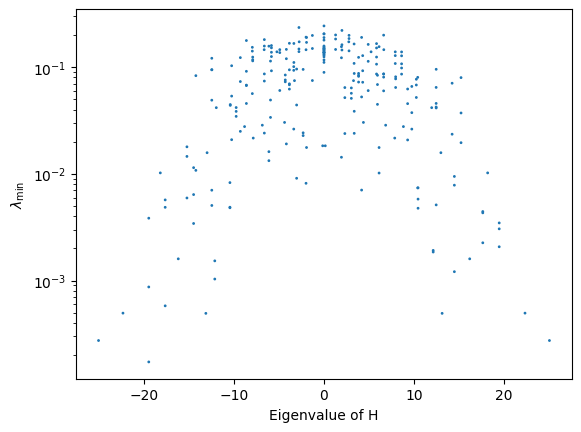

Indices of red points: []
Counts of non-zero eigenvalues of the scarred rdms: []


In [11]:
# rdm - numpy

min_eigenvalues_np = []
min_rdms_np =[]
rdm_eigenvalues_np = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

    # Trace out qubits
    traced_out_density_matrix = ptrace_numpy(density_matrix, keep_qubits, [[2]*N, [2]*N])

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues_np.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms_np.append(traced_out_density_matrix) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues_np.append(eigenvalues_traced) #store the eigenvalues of the scarred rdms

# numpy

# Define the threshold
threshold = 1e-16
min_eigenvalues_np = np.array(min_eigenvalues_np)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues_np if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues_np), color=colors, s=1)

plt.xlabel('Eigenvalue of H')
plt.ylabel(r"$\lambda_{\text{min}}$")
plt.yscale("log")
plt.show()

# Find indices of red points - numpy
red_indices_np = [i for i, y in enumerate(min_eigenvalues_np) if y < threshold]
print(f'Indices of red points: {red_indices_np}')

red_eigenvectors_np = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices_np):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues_np[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms_np[i])}')
    red_eigenvectors_np.append(eigenvectors[:, ind])

#for i in range(len(red_indices_np)):
#    for j in range(len(red_indices_np)):
#        idx1, idx2 = red_indices_np[i], red_indices_np[j]
#        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
#        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues_np[i] - eigenvalues of the scarred rdms - that are non-zero
counts_np = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues_np]
print(f'Counts of non-zero eigenvalues of the scarred rdms: {counts_np}')

In [13]:
half = [0,1,2,3]
# Print selected eigenvalues in red
indices = [106, 107, 108, 147, 148, 149]
for idx in indices:
    print(f"\033[91mEigenvalue[{idx}] = {eigenvalues[idx]}\033[0m")

Eigenvalue[106] = -2.000000000000001
Eigenvalue[107] = -2.0
Eigenvalue[108] = -1.9999999999999982
Eigenvalue[147] = 1.999999999999999
Eigenvalue[148] = 1.999999999999999
Eigenvalue[149] = 2.0


In [14]:
# Compute bipartite entanglement entropy for all eigenstates in the full Hilbert space
numpy_entropies = [entanglement_entropy(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#qutip_entropies = [entanglement_entropy_qutip(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]
#torch_entropies = [entanglement_entropy_torch(eigenvectors[:, i], half, N) for i in tqdm(range(eigenvectors.shape[1]))]

100%|██████████| 256/256 [00:00<00:00, 8835.56it/s]


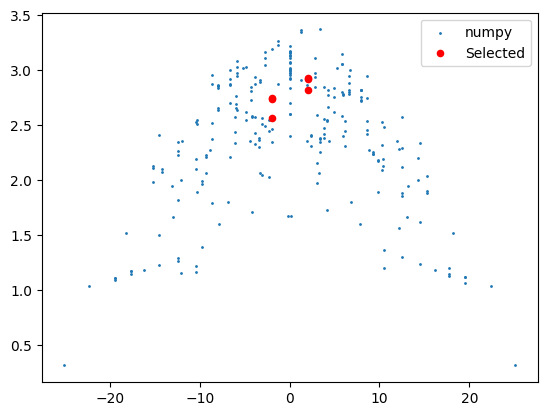

In [ ]:
# Highlight selected eigenvalues in red on a plot
red_indices_np = [106, 107, 108, 147, 148, 149]
plt.scatter(eigenvalues, numpy_entropies, color='C0', s=1, label='numpy')
plt.scatter([eigenvalues[i] for i in red_indices_np],
            [numpy_entropies[i] for i in red_indices_np],
            color='red', s=20, label='Scars')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 3.6664899664142334
Index: 1267, Entropy: 3.8609454779097785
Index: 1268, Entropy: 3.4789638768785487
Index: 1269, Entropy: 3.426551079718025
Index: 1270, Entropy: 3.73950803393908


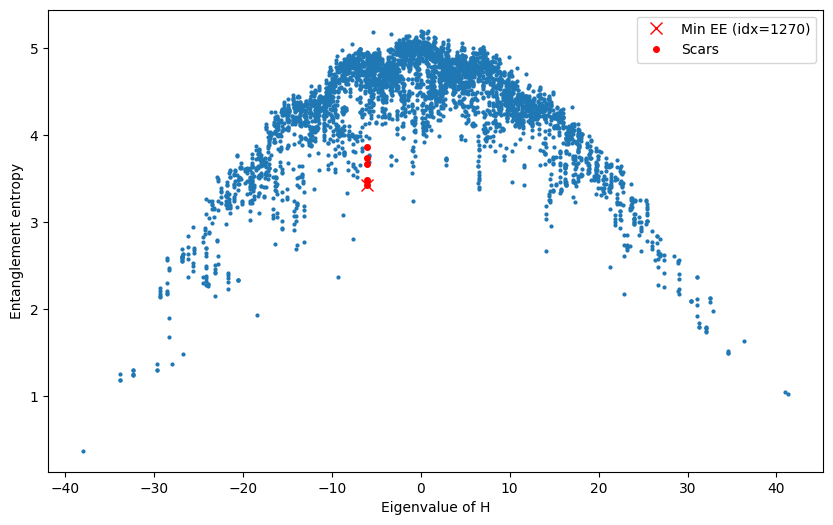

In [ ]:
# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices_np:
    print(f'Index: {i}, Entropy: {numpy_entropies[i]}')

# Find the red index with the lowest entanglement entropy
min_entropy_idx = min(red_indices_np, key=lambda i: numpy_entropies[i])
min_entropy_val = numpy_entropies[min_entropy_idx]

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'C0' for y in min_eigenvalues_np]

# Plot blue points first
for i, color in enumerate(colors):
    if color != 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=2)
# Then plot red points on top
for i, color in enumerate(colors):
    if color == 'red':
        plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=4)

# Plot entanglement entropy with highlighted points
#for i, color in enumerate(colors):
#    size = 3 if color == 'red' else 2
#    plt.plot(eigenvalues[i], numpy_entropies[i], 'o', color=color, markersize=size)

# Mark the scar with the lowest entanglement entropy with a yellow cross
plt.plot(eigenvalues[min_entropy_idx], min_entropy_val, 'x', color='red', markersize=8, label=f'Min EE (idx={min_entropy_idx + 1})')

# Add legend for red points only with text "scars"
red_points = [i for i, color in enumerate(colors) if color == 'red']
if red_points:
    plt.plot([], [], 'o', color='red', markersize=4, label='Scars')

plt.xlabel('Eigenvalue of H')
plt.ylabel('Entanglement entropy')
plt.legend()
plt.show()

In [ ]:
################## PROPERTIES OF EACH SCARRED STATE AND THEIR RDM ######################

In [ ]:
# List to store the number of dependent columns and their indices for each matrix
dependent_columns_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Perform QR decomposition with column pivoting
    Q, R, pivot_indices = qr(rdm, pivoting=True)
    
    # Determine rank using a threshold on the diagonal of R
    tol = 1e-12
    rank = np.sum(np.abs(np.diag(R)) > tol)
    
    # Calculate the number of dependent columns
    num_dependent_columns = 16 - rank
    
    # Identify dependent columns
    dependent_columns = sorted(set(range(16)) - set(pivot_indices[:rank]))
    dependent_columns_info.append((num_dependent_columns, dependent_columns))
    
    print(f"Number of dependent columns: {num_dependent_columns}")
    print(f"Dependent columns indices: {dependent_columns}")
    print("-" * 50)

# Print the results
print("Dependent columns info for each matrix:", dependent_columns_info)

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        result = np.dot(rdm, basis_vector)
        print(f"RDM {idx}, Null Basis Vector {i}:")
        print(f"Result: {result}")
        print(f"Norm of Result: {np.linalg.norm(result)}")

# Print the results
print("Null space information for each matrix computed.")

In [ ]:
# For each RDM, check if any row in its null space basis matrix is (close to) zero
for idx, rdm in enumerate(min_rdms_np):
    null_space_rdm = null_space(rdm)
    for i, row in enumerate(null_space_rdm):
        if np.allclose(row, 0, atol=1e-12):
            print(f"RDM {idx}: Row {i} in null space is (close to) zero.")

In [ ]:
# Count the number of distinct rows in the null space basis of RDM 0
rdm = min_rdms_np[4]
null_space_rdm = null_space(rdm)

# Use np.allclose to group rows that are numerically identical
distinct_rows = []
for i, row in enumerate(null_space_rdm):
    is_new = True
    for drow in distinct_rows:
        if np.allclose(row, drow, atol=1e-12):
            is_new = False
            break
    if is_new:
        distinct_rows.append(row)

print(f"Number of distinct rows in null space basis of RDM 0: {len(distinct_rows)}")

In [ ]:
# Print the binary basis states for each group of identical rows in the null space basis of RDM 0 (5 spins)
# Also print the smallest row index for each group

def index_to_binary(index, num_qubits):
    return format(index, f'0{num_qubits}b')

rdm = min_rdms_np[0]
null_space_rdm = null_space(rdm)

# Group row indices by their unique row (up to numerical tolerance)
groups = []
group_indices = []

for i, row in enumerate(null_space_rdm):
    found = False
    for g, grow in enumerate(groups):
        if np.allclose(row, grow, atol=1e-12):
            group_indices[g].append(i)
            found = True
            break
    if not found:
        groups.append(row)
        group_indices.append([i])

print(f"Number of distinct rows: {len(groups)}")
for indices in group_indices:
    basis_states = [index_to_binary(idx, 5) for idx in indices]
    min_row = min(indices)
    print(f"Row {min_row}: Basis states: {', '.join(basis_states)}")

In [ ]:
# List to store the null space information for each matrix
null_spaces_info = []

for idx, rdm in enumerate(min_rdms_np):
    print(f"RDM Index: {idx}")
    
    # Compute the null space of the RDM
    null_space_rdm = null_space(rdm)
    
    # Store the null space information
    null_spaces_info.append(null_space_rdm)
    
    # Print the null space dimensions and basis vectors
    print(f"Null space dimension: {null_space_rdm.shape[1]}")
    #print(f"Null space basis vectors:\n{null_space_rdm}")
    print("-" * 50)

    # Apply the RDM to each null basis vector
    #for i, basis_vector in enumerate(null_space_rdm.T):  # Transpose to iterate over columns
        #result = np.dot(rdm, basis_vector)
        #print(f"RDM {idx}, Null Basis Vector {i}:")
        #print(f"Result: {result}")
        #print(f"Norm of Result: {np.linalg.norm(result)}")
    
    # Check for repeating rows in the null space basis vectors
    print(f"Repeating rows in the null space basis vectors for RDM {idx}:")
    for i in range(null_space_rdm.shape[0]):
        for j in range(i + 1, null_space_rdm.shape[0]):
            if np.allclose(null_space_rdm[i, :], null_space_rdm[j, :], atol=1e-12):  # Compare rows with a tolerance
                print(f"Row {i} is identical to Row {j}")
    print("-" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    # Print the entire eigenvector
    non_zero_count = 0  # Counter for non-zero components
    print(f"Full Eigenvector {i}:")
    for index, component in enumerate(eigenvector):
        # Set components of the order 10^-12 or smaller to zero
        if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
            eigenvector[index] = 0.0
        else:
            non_zero_count += 1
        binary_basis = index_to_binary(index, N)
        print(f"{binary_basis}: {eigenvector[index]}")

    print(f"Total Non-Zero Components in Scarred Eigenvector {i}: {non_zero_count}")
    print("=" * 50)

In [ ]:
# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")
    
    # Dictionary to track processed coefficients
    processed_coeffs = set()
    
    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component
            
            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue
            
            # Count the number of 1's in the binary representation
            num_ones = binary_basis.count('1')
            
            # Print the coefficient, binary representation, and number of 1's
            print(f"  Coefficient: {coeff}")
            print(f"    Binary Representation: {binary_basis}")
            print(f"    Elements [0, 4, 5, 9]: {binary_basis[0]}, {binary_basis[4]}, {binary_basis[5]}, {binary_basis[9]}")
            print(f"    Number of 1's: {num_ones}")
            
            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)
                    num_ones_neg = binary_basis_neg.count('1')
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Elements [0, 4, 5, 9]: {binary_basis_neg[0]}, {binary_basis_neg[4]}, {binary_basis_neg[5]}, {binary_basis_neg[9]}")
                    print(f"    Number of 1's: {num_ones_neg}")
                    break
            
            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)
    
    print("=" * 50)

In [ ]:
# List to store even swaps numbers
even_swaps_numbers = []

# Dictionary to track spin exchange arrays and their counts
spin_exchange_counts = {}

# Iterate over scarred eigenvectors
for i, eigenvector in enumerate(red_eigenvectors_np):
    print(f"Scarred Eigenvector {i}:")

    # Dictionary to track processed coefficients
    processed_coeffs = set()

    # Iterate over components of the eigenvector
    for index, component in enumerate(eigenvector):
        if np.abs(component) > 1e-12:  # Check if the component is non-zero
            binary_basis = index_to_binary(index, N)
            coeff = component

            # Skip if this coefficient (or its negative) has already been processed
            if coeff in processed_coeffs or -coeff in processed_coeffs:
                continue

            # Check for the negative of the coefficient
            for j, other_component in enumerate(eigenvector):
                if np.abs(other_component + coeff) < 1e-10:  # Compare with tolerance
                    binary_basis_neg = index_to_binary(j, N)

                    # Identify the spins that are exchanged
                    spin_exchange = [
                        k for k in range(N) if binary_basis[k] != binary_basis_neg[k]
                    ]

                    # Compute swaps number
                    swaps_number = len(spin_exchange) // 2

                    # Check if swaps number is odd
                    is_odd = swaps_number % 2 == 1

                    print(f"  Coefficient: {coeff}")
                    print(f"    Binary Representation: {binary_basis}")
                    print(f"  Negative Coefficient: {-coeff}")
                    print(f"    Binary Representation: {binary_basis_neg}")
                    print(f"    Spin Exchange: {spin_exchange}")
                    print(f"    Swaps Number: {swaps_number} (Odd: {is_odd})")

                    # Add to even swaps numbers if swaps number is even
                    if not is_odd:
                        even_swaps_numbers.append(swaps_number)

                    # Track spin exchange arrays
                    spin_exchange_tuple = tuple(spin_exchange)
                    if spin_exchange_tuple in spin_exchange_counts:
                        spin_exchange_counts[spin_exchange_tuple] += 1
                    else:
                        spin_exchange_counts[spin_exchange_tuple] = 1

                    break

            # Mark this coefficient and its negative as processed
            processed_coeffs.add(coeff)
            processed_coeffs.add(-coeff)

    print("=" * 50)

# Print the list of even swaps numbers
print("Even swaps numbers:", even_swaps_numbers)

# Check for repeated spin exchange arrays
repeated_spin_exchanges = [
    spin_exchange for spin_exchange, count in spin_exchange_counts.items() if count > 1
]
if repeated_spin_exchanges:
    print("Repeated spin exchange arrays:", repeated_spin_exchanges)
else:
    print("No repeated spin exchange arrays found.")

print(len(spin_exchange_counts), "spin exchange arrays found.")

In [ ]:
# min_scar

non_zero_count = 0  # Counter for non-zero components

for index, component in enumerate(min_scar):
    # Set components of the order 10^-12 or smaller to zero
    if np.abs(component) < 1e-12: # I noticed that  most components are of the order 10^-13 or smaller - only a handful are mucgh larger
        min_scar[index] = 0.0
    else:
        non_zero_count += 1
    binary_basis = index_to_binary(index, N)
    print(f"{binary_basis}: {np.real(min_scar[index])}")

print(f"Total Non-Zero Components in min_scar: {non_zero_count}")
print("=" * 50)

In [ ]:
# check if other states have 280 non-zero components - it's only the 5 scars!

# Count distinct non_zero_count values
distinct_counts = set()

# Counter to track occurrences of each non_zero_count
non_zero_count_occurrences = Counter()

# Iterate over all eigenvectors
for i in range(eigenvectors.shape[1]):
    eigenvector = eigenvectors[:, i]
    non_zero_count = 0  # Counter for non-zero components
    
    # Count non-zero components
    for component in eigenvector:
        if np.abs(component) >= 1e-12:
            non_zero_count += 1
    
    # Update the counter
    non_zero_count_occurrences[non_zero_count] += 1
    print(f"Total Non-Zero Components in Eigenvector {i}: {non_zero_count}")

# Print the number of distinct non_zero_count values
print(f"Number of distinct non_zero_count values: {len(non_zero_count_occurrences)}")
print(f"Distinct non_zero_count values: {sorted(non_zero_count_occurrences.keys())}")

# Print how many times each distinct non_zero_count appears
print("Occurrences of each non_zero_count:")
for count, occurrences in sorted(non_zero_count_occurrences.items()):
    print(f"Non-Zero Count: {count}, Occurrences: {occurrences}")